In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P1'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here are our files:")
!ls -lasth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P1'
/content/gdrive/MyDrive/GIA/VCA/P1
/content/gdrive/MyDrive/GIA/VCA/P1

And here are our files:
total 15M
4.9M -rw------- 1 root root 4.9M Apr  7 15:23 pt_no_DA.pth
4.9M -rw------- 1 root root 4.9M Apr  7 15:23 npt_DA.pth
4.9M -rw------- 1 root root 4.9M Apr  7 15:21 npt_no_DA.pth
4.0K drwx------ 3 root root 4.0K Mar 27 10:29 ship_dataset


#### Importamos las bibliotecas necesarias para realizar la práctica.

In [2]:
import os, glob, time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

seed = 42
batch_size = 64

## **Tarea 1**: Implementación de Dataset class personalizada para la carga del dataset y su uso en tareas de clasificación.

#### Creamos una clase `Dataset` que hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [3]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()
        self.img_files = glob.glob(os.path.join(image_path, "*.jpg")) + glob.glob(os.path.join(image_path, "*.png"))
        print("Imágenes en .jpg y .png:", len(self.img_files))

        # leemos el csv y recortamos la cabecera
        self.labels = open(csv_path).readlines()[1:]

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        img_path = self.img_files[index]

        name = os.path.splitext(os.path.basename(img_path))[0]

        image = read_image(img_path)
        image = self.transform(image)

        # nos quedamos solo con la etiqueta binaria
        line = self.labels[index].strip()
        _, label = line.split(";")
        label = torch.tensor(int(label), dtype=torch.float32)

        return image, label, name

    def __len__(self):
        return len(self.img_files)

#### Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [4]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

#### Indicamos el directorio de las imágenes y el archivo CSV de etiquetas. Creamos transformaciones personalizadas para las imágenes e instanciamos el dataset ship_dataset. Finalmente, imprimimos el tamaño del dataset.

In [5]:
dir = "ship_dataset"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en .jpg y .png: 294
Tamaño del dataset completo: 294


####  Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

<ipython-input-4-165f0e13db72>:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  new_image[:,:] = tensor[0,:,:]


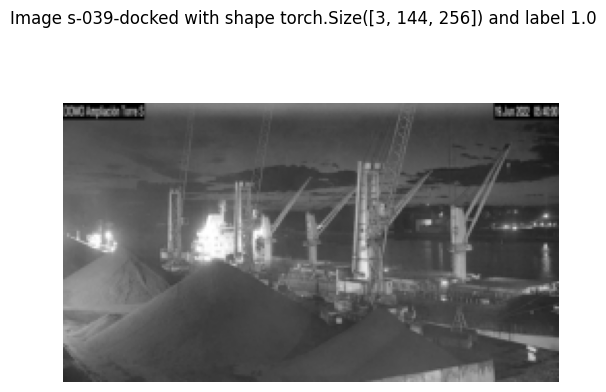

In [6]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

#### Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [7]:
model = squeezenet1_0(weights=None)
#print(model)

In [8]:
class Tail:
    def __init__(self):
        self.model = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size = 1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


mymodel_no_da = nn.Sequential(
    model.features,
    Tail().model
)

image = image.unsqueeze(0)

output = mymodel_no_da(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship. Dada una imagen de entrada predecir la presencia o ausencia de barcos en la escena. Partiendo de un modelo de red base:

### Entrenamiento y validación desde cero, con y sin data augmentation (2 modelos)

In [9]:
# 60-20-20
train_indices, test_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)
test_dataset = data.Subset(ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
def train_model(model, train_loader, val_loader, loss_fn, optim, device, model_name, epochs=20):
    print("Device:", device)
    model.to(device)

    train_losses, val_losses = list(), list()
    best_val_loss = np.inf
    patience = 3
    epochs_without_improvement = 0

    for epoch in range(epochs):
        start_time = time.time()

        model.train() # modo train

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        model.eval() # modo evaluación
        val_loss = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}],",
              f"train loss: {train_loss:.4f},",
              f"val loss: {val_loss:.4f},",
              f"time: {(time.time() - start_time):.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Parando el entrenamiento de forma temprana...")
            break

    torch.save(model.state_dict(), f"{model_name}.pth")

    return model, train_losses, val_losses

def plot_history(train, val):
    plt.clf()
    plt.plot(train, label="train")
    plt.plot(val, label="validation")
    plt.legend(loc="upper right")
    plt.show()

#### Sin Data Augmentation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA",
                                                epochs=99)

Device: cuda:0
Epoch [1/99], train loss: 0.6494, val loss: 0.6893, time: 9.05s
Epoch [2/99], train loss: 0.6260, val loss: 0.6561, time: 5.73s
Epoch [3/99], train loss: 0.5941, val loss: 0.6510, time: 6.97s
Epoch [4/99], train loss: 0.5674, val loss: 0.6361, time: 5.73s
Epoch [5/99], train loss: 0.5561, val loss: 0.6114, time: 6.56s
Epoch [6/99], train loss: 0.5346, val loss: 0.5878, time: 5.78s
Epoch [7/99], train loss: 0.5600, val loss: 0.5651, time: 6.15s
Epoch [8/99], train loss: 0.4938, val loss: 0.6418, time: 6.44s
Epoch [9/99], train loss: 0.5363, val loss: 0.5289, time: 6.11s
Epoch [10/99], train loss: 0.4421, val loss: 0.5428, time: 6.81s
Epoch [11/99], train loss: 0.4229, val loss: 0.6411, time: 7.39s
Epoch [12/99], train loss: 0.4381, val loss: 0.4881, time: 6.22s
Epoch [13/99], train loss: 0.3209, val loss: 0.4880, time: 5.84s
Epoch [14/99], train loss: 0.4318, val loss: 0.6198, time: 6.66s
Epoch [15/99], train loss: 0.3166, val loss: 0.5258, time: 5.78s
Epoch [16/99], trai

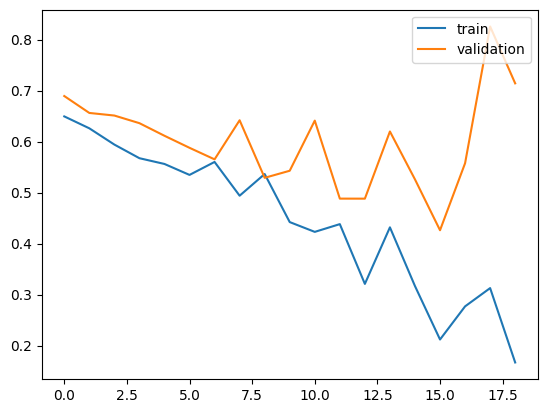

In [12]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [13]:
# Definimos las transformaciones con redimensionamiento y data augmentation
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)

aug_train_dataset = data.Subset(augmented_ship_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_ship_dataset, val_indices)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

Imágenes en .jpg y .png: 294


In [14]:
# Definimos el modelo
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA",
                                                    epochs=99)

Device: cuda:0
Epoch [1/99], train loss: 0.6607, val loss: 0.6885, time: 7.39s
Epoch [2/99], train loss: 0.6670, val loss: 0.6791, time: 5.73s
Epoch [3/99], train loss: 0.6399, val loss: 0.6745, time: 6.88s
Epoch [4/99], train loss: 0.6493, val loss: 0.6684, time: 5.85s
Epoch [5/99], train loss: 0.6127, val loss: 0.7039, time: 6.87s
Epoch [6/99], train loss: 0.6196, val loss: 0.6569, time: 5.72s
Epoch [7/99], train loss: 0.6149, val loss: 0.6420, time: 6.79s
Epoch [8/99], train loss: 0.5622, val loss: 0.6418, time: 5.76s
Epoch [9/99], train loss: 0.5632, val loss: 0.6037, time: 6.78s
Epoch [10/99], train loss: 0.5114, val loss: 0.6035, time: 5.72s
Epoch [11/99], train loss: 0.4323, val loss: 1.4462, time: 6.76s
Epoch [12/99], train loss: 0.7202, val loss: 0.6272, time: 5.76s
Epoch [13/99], train loss: 0.6414, val loss: 0.6453, time: 6.34s
Parando el entrenamiento de forma temprana...


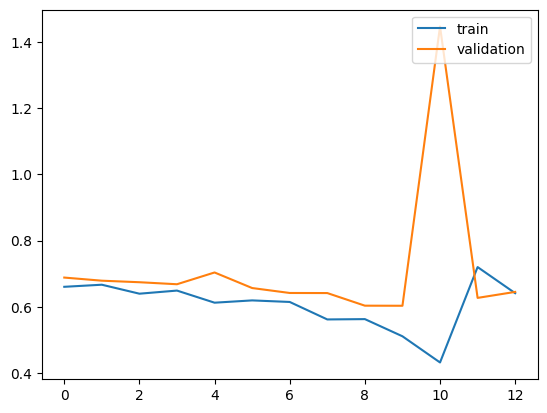

In [16]:
plot_history(train_losses, val_losses)

In [17]:
def accuracy(outputs, targets):
    predicted = (outputs > 0.5).squeeze(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return correct/total

def test_model(model, test_loader):
    print("Device:", device)
    model.eval()

    mean_acc = 0

    with torch.no_grad(): # This disables autograd
        for i, (samples, targets, _) in enumerate(test_loader):
            samples = samples.to(device)
            targets = targets.to(device)

            outputs = model(samples)

            this_acc = accuracy(outputs, targets)

            mean_acc += this_acc

        mean_acc /= (i+1)

    print(f"test accuracy: {(mean_acc*100):.2f} %")

---------------------------------------------------------------------------------------------------------------------------------------

### Refinamiento y validación de modelo preentrenado, con y sin data augmentation (2 modelos).

### Sin Data Augmentation

In [18]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA",
                                                            epochs=99)

Device: cuda:0
Epoch [1/99], train loss: 1.0036, val loss: 0.6666, time: 6.03s
Epoch [2/99], train loss: 0.6186, val loss: 0.6665, time: 6.01s
Epoch [3/99], train loss: 0.6344, val loss: 0.6727, time: 6.39s
Epoch [4/99], train loss: 0.6272, val loss: 0.6503, time: 5.73s
Epoch [5/99], train loss: 0.6083, val loss: 0.6412, time: 6.73s
Epoch [6/99], train loss: 0.6118, val loss: 0.6244, time: 5.69s
Epoch [7/99], train loss: 0.6115, val loss: 0.5835, time: 6.72s
Epoch [8/99], train loss: 0.6246, val loss: 0.5476, time: 5.68s
Epoch [9/99], train loss: 0.5693, val loss: 0.4887, time: 6.78s
Epoch [10/99], train loss: 0.7508, val loss: 1.0269, time: 5.68s
Epoch [11/99], train loss: 0.5737, val loss: 0.6227, time: 6.63s
Epoch [12/99], train loss: 0.5897, val loss: 0.6546, time: 5.62s
Parando el entrenamiento de forma temprana...


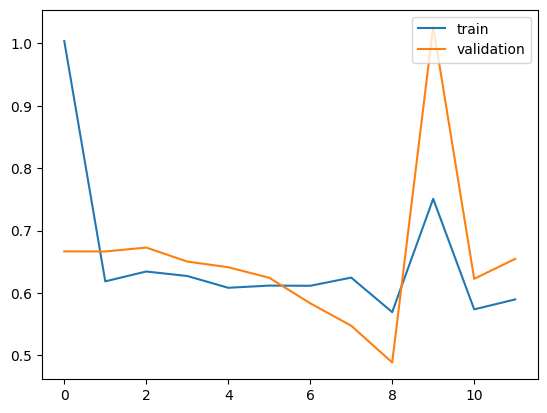

In [19]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [20]:
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA",
                                                            epochs=99)

Device: cuda:0
Epoch [1/99], train loss: 0.5908, val loss: 0.7804, time: 6.76s
Epoch [2/99], train loss: 0.6368, val loss: 0.8480, time: 5.72s
Epoch [3/99], train loss: 0.6500, val loss: 0.6694, time: 6.61s
Epoch [4/99], train loss: 0.6270, val loss: 0.6622, time: 5.72s
Epoch [5/99], train loss: 0.5994, val loss: 0.6741, time: 6.26s
Epoch [6/99], train loss: 0.6038, val loss: 0.6553, time: 6.12s
Epoch [7/99], train loss: 0.5782, val loss: 0.6524, time: 5.89s
Epoch [8/99], train loss: 0.5866, val loss: 0.8051, time: 6.62s
Epoch [9/99], train loss: 0.5659, val loss: 0.6175, time: 5.63s
Epoch [10/99], train loss: 0.5742, val loss: 0.6074, time: 6.75s
Epoch [11/99], train loss: 0.5120, val loss: 0.6051, time: 5.78s
Epoch [12/99], train loss: 0.4766, val loss: 0.7049, time: 6.82s
Epoch [13/99], train loss: 0.5040, val loss: 0.6018, time: 5.72s
Epoch [14/99], train loss: 0.3906, val loss: 0.5266, time: 6.84s
Epoch [15/99], train loss: 0.3866, val loss: 0.6317, time: 5.78s
Epoch [16/99], trai

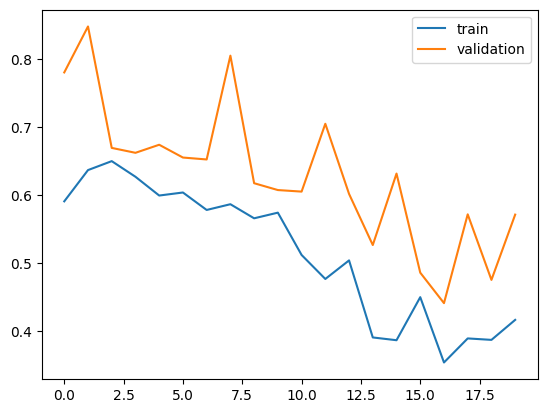

In [21]:
plot_history(train_losses, val_losses)

In [22]:
test_model(mymodel_no_da, test_loader)

Device: cuda:0
test accuracy: 67.80 %


In [23]:
test_model(mymodel_da, test_loader)

Device: cuda:0
test accuracy: 59.32 %


In [24]:
test_model(pretrained_no_da, test_loader)

Device: cuda:0
test accuracy: 59.32 %


In [25]:
test_model(pretrained_da, test_loader)

Device: cuda:0
test accuracy: 74.58 %
